In [1]:
import bisect
import datetime as dt
from functools import reduce
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Cases:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
FILENAME = 'data/time_series_covid19_confirmed_global.csv'

with urllib.request.urlopen(URL) as testfile, open(FILENAME, 'w') as f:
    f.write(testfile.read().decode())

pd_cases = pd.read_csv(FILENAME)

# Recoveries:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
FILENAME = 'data/time_series_covid19_recovered_global.csv'

with urllib.request.urlopen(URL) as testfile, open(FILENAME, 'w') as f:
    f.write(testfile.read().decode())

pd_recs = pd.read_csv(FILENAME)

# Deaths:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
FILENAME = 'data/time_series_covid19_deaths_global.csv'

with urllib.request.urlopen(URL) as testfile, open(FILENAME, 'w') as f:
    f.write(testfile.read().decode())

pd_deaths = pd.read_csv(FILENAME)

In [3]:
LAST_DAY = dt.datetime.utcnow().date() - dt.timedelta(days=1)
FIRST_DAY = LAST_DAY - dt.timedelta(days=30)

cases_countries = pd_cases['Country/Region'].unique()
cases = {c: [] for c in cases_countries}
recs_countries = pd_recs['Country/Region'].unique()
recs = {c: [] for c in recs_countries}
deaths_countries = pd_deaths['Country/Region'].unique()
deaths = {c: [] for c in deaths_countries}

date_strs = sorted(filter(lambda d: d.endswith('/20'), set(pd_cases.columns) & set(pd_recs.columns) & set(pd_deaths.columns)), key=lambda d: (parts := d.split('/')) and (parts[0], int(parts[1])))
dates = [dt.datetime.strptime(ds, '%m/%d/%y').date() for ds in date_strs]

for d in date_strs:
    for c in cases_countries:
        cases[c].append(pd_cases[pd_cases['Country/Region'] == c][d].sum())
    
    for c in recs_countries:
        recs[c].append(pd_recs[pd_recs['Country/Region'] == c][d].sum())
    
    for c in deaths_countries:
        deaths[c].append(pd_deaths[pd_deaths['Country/Region'] == c][d].sum())
        
si = bisect.bisect_left(dates, FIRST_DAY)


def total_cases(include=tuple(cases_countries), exclude=()):
    global cases
    return [sum(c) for c in zip(*map(lambda row: row[1],
                                     filter(lambda row: row[0] in include and row[0] not in exclude,
                                            cases.items())))]

def total_recs(include=tuple(cases_countries), exclude=()):
    global recs
    return [sum(c) for c in zip(*map(lambda row: row[1],
                                     filter(lambda row: row[0] in include and row[0] not in exclude,
                                            recs.items())))]

def total_deaths(include=tuple(cases_countries), exclude=()):
    global deaths
    return [sum(c) for c in zip(*map(lambda row: row[1],
                                     filter(lambda row: row[0] in include and row[0] not in exclude,
                                            deaths.items())))]

def new_cases(include=tuple(cases_countries), exclude=()):
    cases = total_cases(include, exclude)
    return [cases[i] - (cases[i-1] if i > 0 else 0) for i in range(len(cases))]

def growth_factor(include=tuple(cases_countries), exclude=()):
    n_cases = new_cases(include, exclude)
    return [(n_cases[i] / n_cases[i-1]) if i > 0 and n_cases[i-1] > 0 else 1. for i in range(len(n_cases))]

def growth_factor_smooth(include=tuple(cases_countries), exclude=(), days=3):
    n_cases = new_cases(include, exclude)
    return [(n_cases[i] / (sum(prev) / len(prev)))
            if sum(prev := n_cases[max(0, i-days):(i-1)]) > 0 else 1.
            for i in range(len(n_cases))]

def active_cases(include=tuple(cases_countries), exclude=()):
    cases = total_cases(include, exclude)
    recs = total_recs(include, exclude)
    deaths = total_deaths(include, exclude)
    return [cases[i] - recs[i] - deaths[i] for i in range(len(cases))]

def recovery_rate(include=tuple(cases_countries), exclude=()):
    recs = total_recs(include, exclude)
    deaths = total_deaths(include, exclude)
    return [recs[i] / (recs[i] + deaths[i]) for i in range(len(recs))]

In [4]:
data = pd.DataFrame(list(zip(dates, total_cases(), new_cases(), growth_factor(), total_recs(), total_deaths())),
                          columns=['Date', 'Total cases', 'New cases', 'Growth factor', 'Recoveries', 'Deaths'])
data.tail()

,Date,Total cases,New cases,Growth factor,Recoveries,Deaths
76,2020-04-07,1426096,80995,1.109733,300054,81865
77,2020-04-08,1511104,85008,1.049546,328661,88338
78,2020-04-09,1595350,84246,0.991036,353975,95455
79,2020-04-10,1691719,96369,1.143900,376096,102525
80,2020-04-11,1771514,79795,0.828015,402110,108503


<ipython-input-3-c552dfab8ce5>:68: RuntimeWarning: invalid value encountered in long_scalars
  return [recs[i] / (recs[i] + deaths[i]) for i in range(len(recs))]


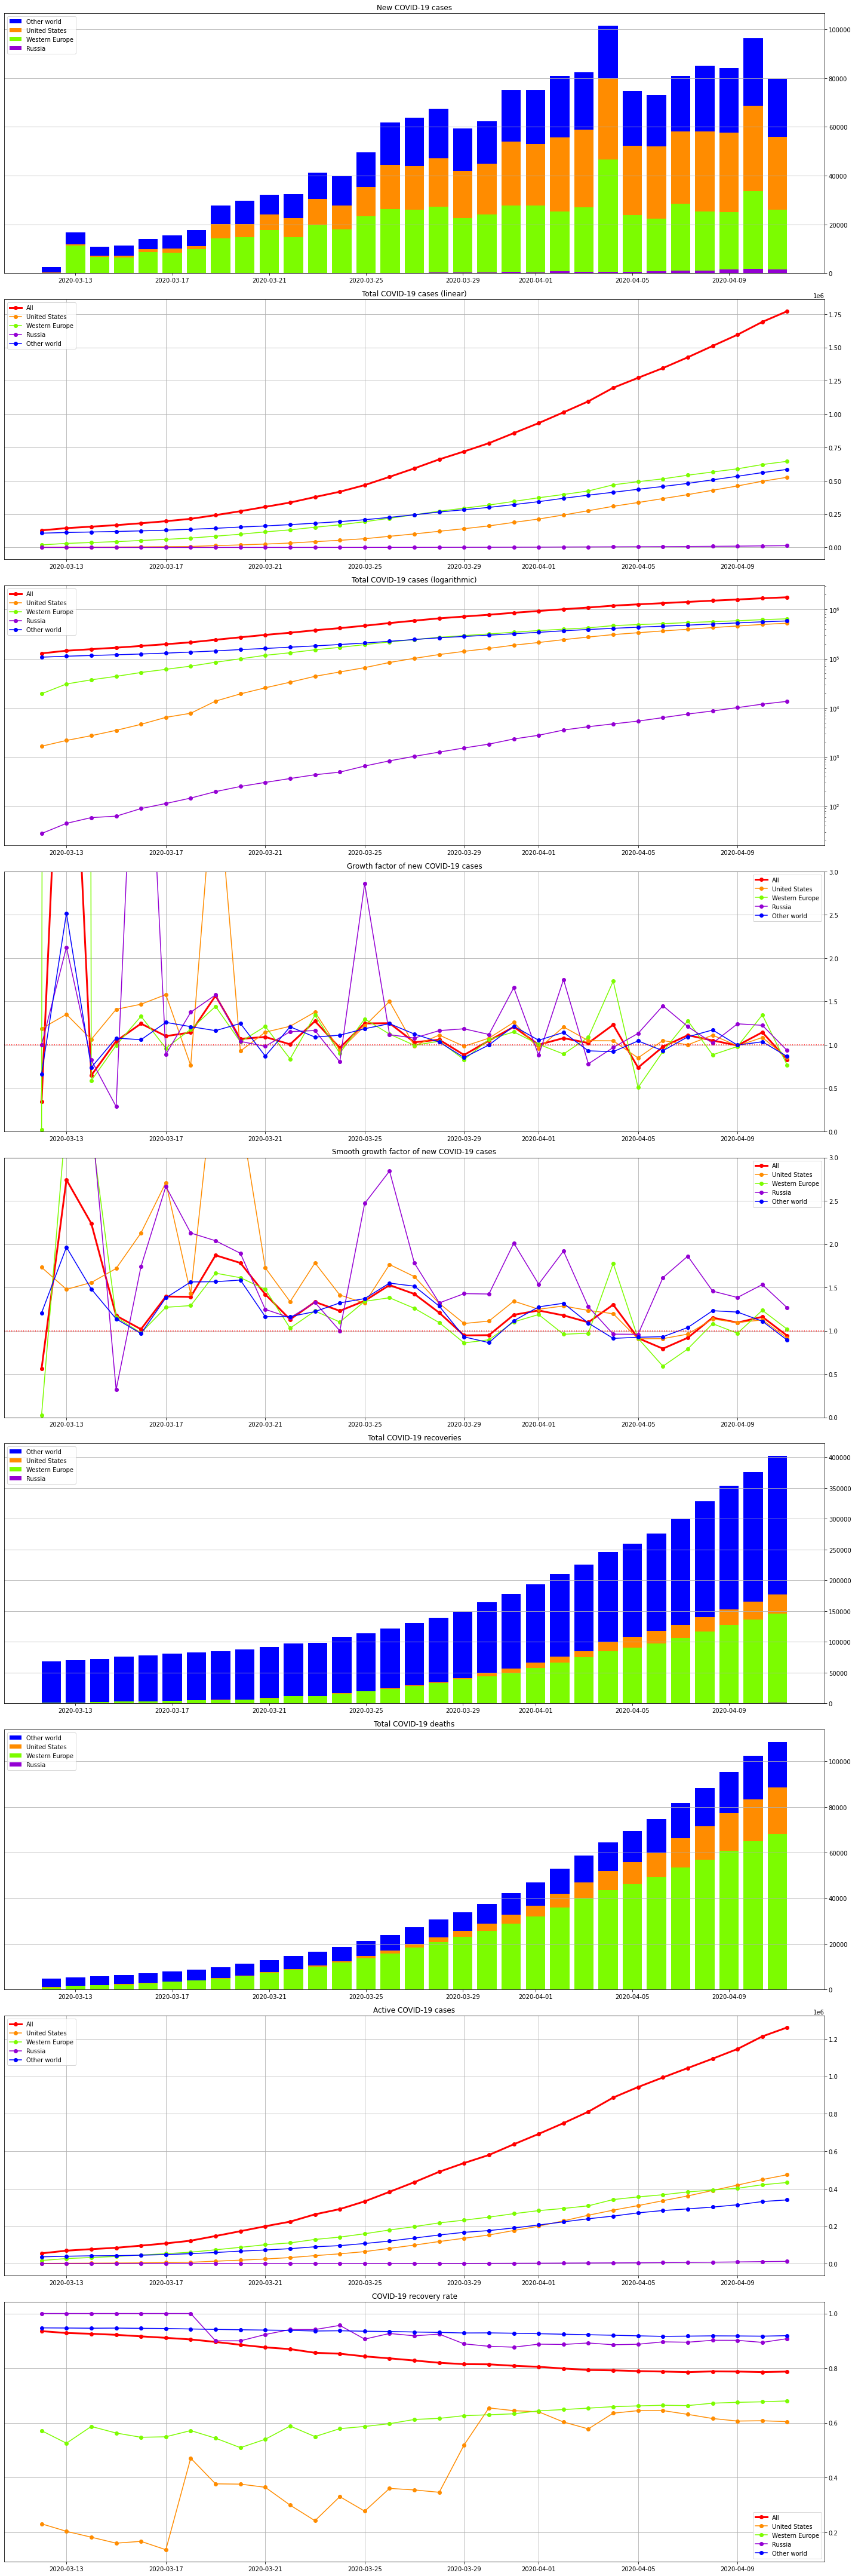

In [5]:
US = ('US',)
RUSSIA = ('Russia',)
WESTERN_EUROPE = ('Andorra', 'Austria', 'Belgium', 'France', 'Ireland',
                  'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain',
                  'Switzerland', 'United Kingdom')
ALL = US + RUSSIA + WESTERN_EUROPE

ALL_PARAMS = {'color': '#ff0000', 'label': 'All', 'linewidth': 3.}
US_PARAMS = {'color': '#ff8c00', 'label': 'United States'}
WE_PARAMS = {'color': '#7cfc00', 'label': 'Western Europe'}
RUSSIA_PARAMS = {'color': '#9400d3', 'label': 'Russia'}
OTHER_PARAMS = {'color': '#0000ff', 'label': 'Other world'}

RESULT_FILE = 'graphs/COVID-19 plots.pdf'


fig = plt.figure(figsize=(20, 60))

nc_ax = plt.subplot(911)
nc_ax.bar(dates[si:], new_cases()[si:], **OTHER_PARAMS)
nc_ax.bar(dates[si:], new_cases(include=ALL)[si:], **US_PARAMS)
nc_ax.bar(dates[si:], new_cases(include=WESTERN_EUROPE + RUSSIA)[si:], **WE_PARAMS)
nc_ax.bar(dates[si:], new_cases(include=RUSSIA)[si:], **RUSSIA_PARAMS)
nc_ax.yaxis.grid(True)
nc_ax.yaxis.tick_right()
nc_ax.legend()
nc_ax.set_title('New COVID-19 cases')

tc_ax = plt.subplot(912)
tc_ax.plot(dates[si:], total_cases()[si:], marker='o', **ALL_PARAMS)
tc_ax.plot(dates[si:], total_cases(include=US)[si:], marker='o', **US_PARAMS)
tc_ax.plot(dates[si:], total_cases(include=WESTERN_EUROPE)[si:], marker='o', **WE_PARAMS)
tc_ax.plot(dates[si:], total_cases(include=RUSSIA)[si:], marker='o', **RUSSIA_PARAMS)
tc_ax.plot(dates[si:], total_cases(exclude=ALL)[si:], marker='o', **OTHER_PARAMS)
tc_ax.grid(True)
tc_ax.yaxis.tick_right()
tc_ax.legend()
tc_ax.set_title('Total COVID-19 cases (linear)')

tc_log_ax = plt.subplot(913)
tc_log_ax.plot(dates[si:], total_cases()[si:], marker='o', **ALL_PARAMS)
tc_log_ax.plot(dates[si:], total_cases(include=US)[si:], marker='o', **US_PARAMS)
tc_log_ax.plot(dates[si:], total_cases(include=WESTERN_EUROPE)[si:], marker='o', **WE_PARAMS)
tc_log_ax.plot(dates[si:], total_cases(include=RUSSIA)[si:], marker='o', **RUSSIA_PARAMS)
tc_log_ax.plot(dates[si:], total_cases(exclude=ALL)[si:], marker='o', **OTHER_PARAMS)
tc_log_ax.set_yscale('log')
tc_log_ax.grid(True)
tc_log_ax.yaxis.tick_right()
tc_log_ax.legend()
tc_log_ax.set_title('Total COVID-19 cases (logarithmic)')

gf_ax = plt.subplot(914)
gf_ax.plot(dates[si:], growth_factor()[si:], marker='o', **ALL_PARAMS)
gf_ax.plot(dates[si:], growth_factor(include=US)[si:], marker='o', **US_PARAMS)
gf_ax.plot(dates[si:], growth_factor(include=WESTERN_EUROPE)[si:], marker='o', **WE_PARAMS)
gf_ax.plot(dates[si:], growth_factor(include=RUSSIA)[si:], marker='o', **RUSSIA_PARAMS)
gf_ax.plot(dates[si:], growth_factor(exclude=ALL)[si:], marker='o', **OTHER_PARAMS)
gf_ax.axhline(y=1.0, c='r', ls=':')
gf_ax.set_ylim(bottom=0, top=3)
gf_ax.grid(True)
gf_ax.yaxis.tick_right()
gf_ax.legend()
gf_ax.set_title('Growth factor of new COVID-19 cases')

gfs_ax = plt.subplot(915)
gfs_ax.plot(dates[si:], growth_factor_smooth()[si:], marker='o', **ALL_PARAMS)
gfs_ax.plot(dates[si:], growth_factor_smooth(include=US)[si:], marker='o', **US_PARAMS)
gfs_ax.plot(dates[si:], growth_factor_smooth(include=WESTERN_EUROPE)[si:], marker='o', **WE_PARAMS)
gfs_ax.plot(dates[si:], growth_factor_smooth(include=RUSSIA)[si:], marker='o', **RUSSIA_PARAMS)
gfs_ax.plot(dates[si:], growth_factor_smooth(exclude=ALL)[si:], marker='o', **OTHER_PARAMS)
gfs_ax.axhline(y=1.0, c='r', ls=':')
gfs_ax.set_ylim(bottom=0, top=3)
gfs_ax.grid(True)
gfs_ax.yaxis.tick_right()
gfs_ax.legend()
gfs_ax.set_title('Smooth growth factor of new COVID-19 cases')

tr_ax = plt.subplot(916)
tr_ax.bar(dates[si:], total_recs()[si:], **OTHER_PARAMS)
tr_ax.bar(dates[si:], total_recs(include=ALL)[si:], **US_PARAMS)
tr_ax.bar(dates[si:], total_recs(include=WESTERN_EUROPE + RUSSIA)[si:], **WE_PARAMS)
tr_ax.bar(dates[si:], total_recs(include=RUSSIA)[si:], **RUSSIA_PARAMS)
tr_ax.yaxis.grid(True)
tr_ax.yaxis.tick_right()
tr_ax.legend()
tr_ax.set_title('Total COVID-19 recoveries')

td_ax = plt.subplot(917)
td_ax.bar(dates[si:], total_deaths()[si:], **OTHER_PARAMS)
td_ax.bar(dates[si:], total_deaths(include=ALL)[si:], **US_PARAMS)
td_ax.bar(dates[si:], total_deaths(include=WESTERN_EUROPE + RUSSIA)[si:], **WE_PARAMS)
td_ax.bar(dates[si:], total_deaths(include=RUSSIA)[si:], **RUSSIA_PARAMS)
td_ax.yaxis.grid(True)
td_ax.yaxis.tick_right()
td_ax.legend()
td_ax.set_title('Total COVID-19 deaths')

tac_ax = plt.subplot(918)
tac_ax.plot(dates[si:], active_cases()[si:], marker='o', **ALL_PARAMS)
tac_ax.plot(dates[si:], active_cases(include=US)[si:], marker='o', **US_PARAMS)
tac_ax.plot(dates[si:], active_cases(include=WESTERN_EUROPE)[si:], marker='o', **WE_PARAMS)
tac_ax.plot(dates[si:], active_cases(include=RUSSIA)[si:], marker='o', **RUSSIA_PARAMS)
tac_ax.plot(dates[si:], active_cases(exclude=ALL)[si:], marker='o', **OTHER_PARAMS)
tac_ax.grid(True)
tac_ax.yaxis.tick_right()
tac_ax.legend()
tac_ax.set_title('Active COVID-19 cases')

rr_ax = plt.subplot(919)
rr_ax.plot(dates[si:], recovery_rate()[si:], marker='o', **ALL_PARAMS)
rr_ax.plot(dates[si:], recovery_rate(include=US)[si:], marker='o', **US_PARAMS)
rr_ax.plot(dates[si:], recovery_rate(include=WESTERN_EUROPE)[si:], marker='o', **WE_PARAMS)
rr_ax.plot(dates[si:], recovery_rate(include=RUSSIA)[si:], marker='o', **RUSSIA_PARAMS)
rr_ax.plot(dates[si:], recovery_rate(exclude=ALL)[si:], marker='o', **OTHER_PARAMS)
rr_ax.grid(True)
rr_ax.yaxis.tick_right()
rr_ax.legend()
rr_ax.set_title('COVID-19 recovery rate')

plt.tight_layout()
plt.savefig(RESULT_FILE)
plt.show()